In [384]:
import numpy as np
import matplotlib.pyplot as plt
import random
from google.colab import drive
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1 - INPUT DATA

In [385]:
# Physical Data
L = 2.0  #m
H = 1.0  #m
P_in = 101325  #Pa
T_in = 293  #K
Rho_in = P_in / (287*T_in)  #kg/m^3

# Numeral Data
N = 200
M = 100
rho_gamma = 10E3  # there will be 3 different cases: 10, 1000 and 10E6
gamma = Rho_in/rho_gamma
dt = 0.1  # time step
delta = 0.000001  # accuracy
delta_N = L/N
delta_M = H/M
t_max = 1000000 # G-S loop steps.
time_max = 1000000 # Time loop steps.

MESH

In [386]:
# Control Volumes
X_cv = np.linspace(0, L, N+1)
X_cv_2 = np.linspace(-L/2, L/2, N+1)
Y_cv = np.linspace(0, H, M+1)

#print(X_cv)
# Mesh Generation
X_P  = np.zeros(N+2)
X_P_2  = np.zeros(N+2)
Y_P  = np.zeros(M+2)

for i in range(1, N+1):
    X_P[i] = (X_cv[i-1] + X_cv[i])/2
    X_P_2[i] = (X_cv_2[i-1] + X_cv_2[i])/2

for j in range(1, M+1):
    Y_P[j] = (Y_cv[j-1] + Y_cv[j])/2

X_P[0] = X_cv[0]
X_P[-1] = X_cv[-1]
X_P_2[0] = X_cv_2[0]
X_P_2[-1] = X_cv_2[-1]
Y_P[0] = Y_cv[0]
Y_P[-1] = Y_cv[-1]

#print(X_P)
# Velocity Field
Vx = np.zeros((M+2, N+2))
Vy = np.zeros((M+2, N+2))
for i in range(N+2):
  for j in range(M+2):
    Vx[j][i] = 2*Y_P[j]*(1-(X_P_2[i])**2)
    Vy[j][i] = -2*X_P_2[i]*(1-(Y_P[j])**2)
#print(Vx)
#print(Vy)
# Define Metrics
a_E = np.zeros((M+2,N+2))
a_W = np.zeros((M+2,N+2))
a_S = np.zeros((M+2,N+2))
a_N = np.zeros((M+2,N+2))
b_P = np.zeros((M+2,N+2))
a_P = np.zeros((M+2,N+2))
m_e = 0.0
m_s = 0.0
m_w = 0.0
m_n = 0.0
D_e = 0.0
D_w = 0.0
D_n = 0.0
D_s = 0.0
phi = np.zeros((M+2,N+2))
phi0 = np.zeros((M+2,N+2))
phi_aux = np.zeros((M+2,N+2))

INITIAL MAP

In [387]:
# Internal nodes
for i in range(1, N+1):
    for j in range(1, M+1):
        phi0[j][i] = 1.0
        phi[j][i] = 1.0

# Inlet nodes
for i in range(int((N+2) / 2)):
    for j in range(M+2):
        phi0[0][i] = 1.0 + np.tanh(10.0 * (2.0 * X_P_2[i] + 1.0))
        phi[0][i] = 1.0 + np.tanh(10.0 * (2.0 * X_P_2[i] + 1.0))

# Walls
for i in range(N+2):
    for j in range(M+2):
        phi0[j][0]  = 1.0 - np.tanh(10.0)
        phi0[-1][i] = 1.0 - np.tanh(10.0)
        phi0[j][-1] = 1.0 - np.tanh(10.0)
        phi[j][0]  = 1.0 - np.tanh(10.0)
        phi[-1][i] = 1.0 - np.tanh(10.0)
        phi[j][-1] = 1.0 - np.tanh(10.0)

PREVIOUS CALCULATIONS

In [388]:
def scheme(type, Pe):
  if type == 0:
    return 1
  if type == 1:
    return np.abs(Pe)/(np.exp(np.abs(Pe))-1)

# Internal nodes
type = 0 ################################# 0 --> upwind & 1 --> Exponential

for i in range(1, N+1):
  for j in range(1, M+1):
      De = (gamma*delta_M)/np.abs(X_P_2[i] - X_P_2[i + 1])
      m_e = Rho_in * (Vx[j][i + 1] + Vx[j][i]) * delta_M / 2.0
      Pe = m_e/De
      a_E[j][i]=De * scheme(type,Pe) - ((m_e - np.abs(m_e)) / 2.0)
      #a_E[j][i]=De * scheme(type,Pe) + np.max((-1)*m_e, 0)

      Dw = (gamma*delta_M)/np.abs(X_P_2[i] - X_P_2[i - 1])
      m_w = Rho_in * (Vx[j][i - 1] + Vx[j][i]) * delta_M / 2.0
      Pw = m_w/Dw
      #a_W[j][i]=Dw * scheme(type,Pw) + np.max((1)*m_w, 0)
      a_W[j][i]=Dw * scheme(type,Pw) + ((m_w + np.abs(m_w)) / 2.0)

      Dn = (gamma*delta_N)/np.abs(Y_P[j] - Y_P[j + 1])
      m_n = Rho_in * (Vy[j + 1][i] + Vy[j][i]) * delta_N / 2.0
      Pn = m_n/Dn
      #a_N[j][i]=Dn * scheme(type,Pn) + np.max((-1)*m_n, 0)
      a_N[j][i]=Dn * scheme(type,Pn) - ((m_n - np.abs(m_n)) / 2.0)

      Ds = (gamma*delta_N)/np.abs(Y_P[j] - Y_P[j - 1])
      m_s = Rho_in * (Vy[j - 1][i] + Vy[j][i]) * delta_N / 2.0
      Ps = m_s/Ds
      #a_S[j][i]=Ds * scheme(type,Ps) + np.max((1)*m_s, 0)
      a_S[j][i]=Ds * scheme(type,Ps) + ((m_s + np.abs(m_s)) / 2.0)
      #print(Ds)

      a_P[j][i] = a_E[j][i] + a_W[j][i] + a_N[j][i] + a_S[j][i] + (Rho_in * delta_N * delta_M)/dt

#print(a_N)
#print(gamma)
#print(delta_M)


EVALUATION DISCRETIZATION COEFFICIENTS

In [389]:
# Inlet Dirichlet
for i in range(int((N+2) / 2)):
    for j in range(M+2):
        a_E[0,i]  = 0.0
        a_W[0,i]  = 0.0
        a_N[0,i]  = 0.0
        a_S[0,i]  = 0.0
        b_P[0,i]  = 1 + np.tanh(10.0 * (2.0 * X_P_2[i] + 1.0))
        a_P[0,i]  = 1.0

# Outlet Neumann
for i in range(int((N+2) / 2), N+2):
    for j in range(M+2):
        a_E[0,i]  = 0.0
        a_W[0,i]  = 0.0
        a_N[0,i]  = 1.0
        a_S[0,i]  = 0.0
        b_P[0,i]  = 0.0
        a_P[0,i]  = 1.0

# Walls Dirichlet
for i in range(N+2):
    for j in range(M+2):
        # Left
        a_E[j][0]  = 0.0
        a_W[j][0]  = 0.0
        a_N[j][0]  = 0.0
        a_S[j][0]  = 0.0
        b_P[j][0]  = 1.0 - np.tanh(10.0)
        a_P[j][0]  = 1.0
        # Right
        a_E[j][-1] = 0
        a_W[j][-1] = 0
        a_N[j][-1] = 0
        a_S[j][-1] = 0
        a_P[j][-1] = 1
        b_P[j][-1] = 1.0 - np.tanh(10.0)
        # Top
        a_E[-1][i] = 0.0
        a_W[-1][i] = 0.0
        a_N[-1][i] = 0.0
        a_S[-1][i] = 0.0
        a_P[-1][i] = 1.0
        b_P[-1][i] = 1.0 - np.tanh(10.0)


GAUSS-SEIDEL METHOD

In [390]:
for time in range (time_max):
  r2 = np.sum(phi0)
  phi_aux = phi0
  for t in range(t_max):
    for i in range(int((N+2) / 2), N+2):
                phi_aux[0,i] = phi_aux[1,i]
    # Internal Nodes
    for i in range (1, N+1):
        for j in range (1, M+1):
          b_P[j][i] = ((Rho_in * delta_N * delta_M)/dt) * phi_aux[j][i]
          phi[j][i] = (a_E[j][i] * phi_aux[j][i+1] + a_W[j][i]*phi_aux[j][i-1] + a_N[j][i] * phi_aux[j+1][i] + a_S[j][i] * phi_aux[j-1][i] + b_P[j][i])/a_P[j][i]

    r = np.sum(phi_aux)
    sum = np.sum(phi)

    if np.abs(sum-r) <= delta:
      break

    else:
      phi_aux = phi
  sum2 = np.sum(phi)
  if np.abs(sum2 - r2) <= delta:
    print("Time loop has converged successfully")
    break
  else:
    phi0 = phi


Time loop has converged successfully


In [391]:
# Ruta a la carpeta en la que deseas guardar el archivo binario
ruta_carpeta = '/content/drive/My Drive/Compu/Assignment 2'

# Asegúrate de que la carpeta exista
os.makedirs(ruta_carpeta, exist_ok=True)

# Nombre del archivo binario
nombre_archivo = f'phi_10E3_UDS_{N}x{M}.bin'

# Ruta completa al archivo
ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)

# Guarda el array en el archivo binario
with open(ruta_archivo, 'wb') as archivo:
    np.save(archivo, phi)

print(f"El archivo se ha guardado en: {ruta_archivo}")

El archivo se ha guardado en: /content/drive/My Drive/Compu/Assignment 2/phi_10E3_UDS_200x100.bin


VECTORS

In [392]:
x_exp = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
phi_ten     = [1.989, 1.402, 1.146, 0.946, 0.775, 0.621, 0.480, 0.349, 0.227, 0.111, 0.000]
phi_mil   = [2.0000, 1.9990, 1.9997, 1.9850, 1.8410, 0.9510, 0.1540, 0.0010, 0.0000, 0.0000, 0.0000]
phi_million   = [2.000, 2.000, 2.000, 1.999, 1.964, 1.000, 0.036, 0.001, 0.000, 0.000, 0.000]

x_plot   = np.zeros(int((N+2) / 2))
phi_plot = np.zeros(int((N+2) / 2))

<Figure size 640x480 with 0 Axes>

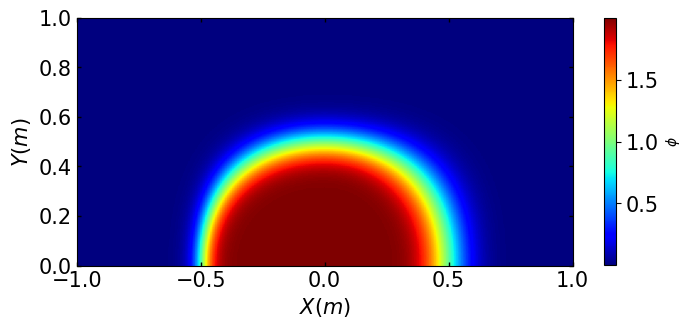

In [393]:
# Figure specifications
fontsize=15

# Start first plot
plt.figure(1)
plt.figure(figsize = (8,8))
plt.tick_params(axis='both', which='both',length=3, width=1.0,
labelsize=15, right=True, top=True, direction='in') # For ticks in borders

# Figure labels
plt.xlabel(r"$X(m)$", fontsize=fontsize)
plt.ylabel(r"$Y(m)$", fontsize=fontsize)

# Plot
#plt.contour(X_P_2, Y_P, phi, levels=20, colors='black', linewidths=0.5)
plt.imshow(phi, cmap= 'jet', extent=(X_P_2.min(), X_P_2.max(), Y_P.min(), Y_P.max()), origin='lower')
plt.colorbar( label = r"$\phi$", shrink = 0.4 ).ax.tick_params( labelsize =15)

plt.show(1)


Error 10E3 UDS: 1.4733562268096805
Error 10E3 EDS: 1.4132550019815198


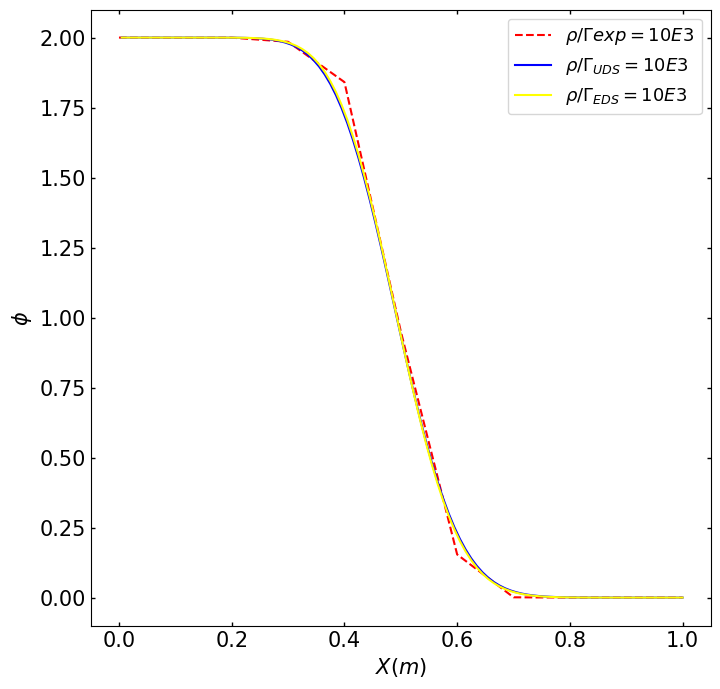

In [394]:
# Vectors for outlet plot

x_exp = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
phi_10_exp     = [1.989, 1.402, 1.146, 0.946, 0.775, 0.621, 0.480, 0.349, 0.227, 0.111, 0.000]
phi_10E3_exp  = [2.0000, 1.9990, 1.9997, 1.9850, 1.8410, 0.9510, 0.1540, 0.0010, 0.0000, 0.0000, 0.0000]
phi_10E6_exp   = [2.000, 2.000, 2.000, 1.999, 1.964, 1.000, 0.036, 0.001, 0.000, 0.000, 0.000]

x_plot   = np.zeros(int((N+2) / 2))
phi_10_plot_UDS = np.zeros(int((N+2) / 2))
phi_10E3_plot_UDS = np.zeros(int((N+2) / 2))
phi_10E6_plot_UDS = np.zeros(int((N+2) / 2))
phi_10_plot_EDS = np.zeros(int((N+2) / 2))
phi_10E3_plot_EDS = np.zeros(int((N+2) / 2))
phi_10E6_plot_EDS = np.zeros(int((N+2) / 2))

#ruta_archivo_10_UDS = '/content/drive/My Drive/Compu/Assignment 2/phi_10_UDS.bin'
ruta_archivo_10E3_UDS = '/content/drive/My Drive/Compu/Assignment 2/phi_10E3_UDS_200x100.bin'
#ruta_archivo_10E6_UDS = '/content/drive/My Drive/Compu/Assignment 2/phi_10E6_UDS.bin'
#ruta_archivo_10_EDS = '/content/drive/My Drive/Compu/Assignment 2/phi_10_EDS.bin'
ruta_archivo_10E3_EDS = '/content/drive/My Drive/Compu/Assignment 2/phi_10E3_EDS_200x100.bin'
#ruta_archivo_10E6_EDS = '/content/drive/My Drive/Compu/Assignment 2/phi_10E6_EDS.bin'

#with open(ruta_archivo_10_UDS, 'rb') as file:
#  phi_10_UDS = np.load(file)
with open(ruta_archivo_10E3_UDS, 'rb') as file:
  phi_10E3_UDS = np.load(file)
#with open(ruta_archivo_10E6_UDS, 'rb') as file:
#  phi_10E6_UDS = np.load(file)
#with open(ruta_archivo_10_EDS, 'rb') as file:
#  phi_10_EDS = np.load(file)
with open(ruta_archivo_10E3_EDS, 'rb') as file:
  phi_10E3_EDS = np.load(file)
#with open(ruta_archivo_10E6_EDS, 'rb') as file:
#  phi_10E6_EDS = np.load(file)

for i in range(int((N+2) / 2), N+2):
  x_plot[i - int((N+2) / 2)] = X_P_2[i]
  #phi_10_plot_UDS[i - int((N+2) / 2)] = phi_10_UDS[0][i]
  phi_10E3_plot_UDS[i - int((N+2) / 2)] = phi_10E3_UDS[0][i]
  #phi_10E6_plot_UDS[i - int((N+2) / 2)] = phi_10E6_UDS[0][i]
  #phi_10_plot_EDS[i - int((N+2) / 2)] = phi_10_EDS[0][i]
  phi_10E3_plot_EDS[i - int((N+2) / 2)] = phi_10E3_EDS[0][i]
  #phi_10E6_plot_EDS[i - int((N+2) / 2)] = phi_10E6_EDS[0][i]

# Compute the errors
#err_ref_10 = np.sum(phi_10_exp)/len(phi_10_exp)
err_ref_10E3 = np.sum(phi_10E3_exp)/len(phi_10E3_exp)
#err_ref_10E6 = np.sum(phi_10E6_exp)/len(phi_10E6_exp)

#err_10_UDS = np.sum(phi_10_plot_UDS)/len(phi_10_plot_UDS)
err_10E3_UDS = np.sum(phi_10E3_plot_UDS)/len(phi_10E3_plot_UDS)
#err_10E6_UDS = np.sum(phi_10E6_plot_UDS)/len(phi_10E6_plot_UDS)

#err_10_EDS = np.sum(phi_10_plot_EDS)/len(phi_10_plot_EDS)
err_10E3_EDS = np.sum(phi_10E3_plot_EDS)/len(phi_10E3_plot_EDS)
#err_10E6_EDS = np.sum(phi_10E6_plot_EDS)/len(phi_10E6_plot_EDS)

#error_10_UDS = (np.abs(err_10_UDS-err_ref_10)/err_ref_10)*100
error_10E3_UDS = (np.abs(err_10E3_UDS-err_ref_10E3)/err_ref_10E3)*100
#error_10E6_UDS = (np.abs(err_10E6_UDS-err_ref_10E6)/err_ref_10E6)*100

#error_10_EDS = (np.abs(err_10_EDS-err_ref_10)/err_ref_10)*100
error_10E3_EDS = (np.abs(err_10E3_EDS-err_ref_10E3)/err_ref_10E3)*100
#error_10E6_EDS = (np.abs(err_10E6_EDS-err_ref_10E6)/err_ref_10E6)*100

#print(f'Error 10 UDS:', error_10_UDS)
print(f'Error 10E3 UDS:', error_10E3_UDS)
#print(f'Error 10E6 UDS:', error_10E6_UDS)
#print(f'Error 10 EDS:', error_10_EDS)
print(f'Error 10E3 EDS:', error_10E3_EDS)
#print(f'Error 10E6 EDS:', error_10E6_EDS)
## Figure specifications
fontsize=15
plt.figure(figsize = (8,8))
plt.tick_params(axis='both', which='both',length=3, width=1.0,
labelsize=15, right=True, top=True, direction='in') # For ticks in borders

# Figure labels
plt.xlabel(r"$X(m)$", fontsize=fontsize)
plt.ylabel(r"$\phi$", fontsize=fontsize)

# Plot
#plt.plot(x_exp, phi_10_exp, color="blue",linestyle = "dashed", label=r"$\rho/\Gamma exp =10$")
#plt.plot(x_plot, phi_10_plot, color="blue",linestyle = "solid", label=r"$\rho/\Gamma=10$")
plt.plot(x_exp, phi_10E3_exp, color="red",linestyle = "dashed", label=r"$\rho/\Gamma exp =10E3$")
plt.plot(x_plot, phi_10E3_plot_UDS, color="blue",linestyle = "solid", label=r"$\rho/\Gamma_{UDS}=10E3$")
plt.plot(x_plot, phi_10E3_plot_EDS, color="yellow",linestyle = "solid", label=r"$\rho/\Gamma_{EDS}=10E3$")
#plt.plot(x_exp, phi_10E6_exp, color="green",linestyle = "dashed", label=r"$\rho/\Gamma exp =10E6$")
#plt.plot(x_plot, phi_10E6_plot, color="green",linestyle = "solid", label=r"$\rho/\Gamma=10E6$")
#
# Legend specifications
plt.legend(fontsize=fontsize-2, loc='upper right')


plt.show()
